# Capstone project: Opening a New Pub in London
_Michael Turek_  
_June 12, 2020_

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

import json
import requests

import geojson
import geopy.distance

import folium

## Step 1 - Data loading and preprocessing

As the first step, we will load, pre-process and clean the data required to conduct our analysis. All data used is publicly available and can be found in the following locations:
- [London demographic data](https://data.london.gov.uk/dataset/ward-profiles-and-atlas)  
- [UK geographic data](https://martinjc.github.io/UK-GeoJSON/)
- [Foursquare venue data](https://foursquare.com)

### 1A - Load in the ward-level dataset with demographic data

In [2]:
# Load data from the downloaded Excel file

df = pd.read_excel('london_ward_profiles.xls', sheet_name='Data')
df.rename(columns = {'New code': 'Code'}, inplace=True)
df.drop_duplicates(subset=['Code'], keep='first', inplace=True)
df.dropna(subset=['Code'], axis=0, inplace=True)
df.drop('Old code', axis=1, inplace=True)

In [3]:
# Drop unneeded columns and rename the rest

df_map = pd.read_excel('column_mapping.xlsx', sheet_name='Mapping')

df_drop = df_map[df_map['New column name'] == 'drop']
cols_to_drop = df_drop['Original column name'].values
df.drop(columns = cols_to_drop, inplace=True)

df_rename = df_map[df_map['New column name'] != 'drop']
cols_to_rename = dict(zip(df_rename['Original column name'], df_rename['New column name']))
df.rename(columns = cols_to_rename, inplace=True)

df.head()

Ward name       Code Population  \
0                         City of London  E09000001       8100   
1           Barking and Dagenham - Abbey  E05000026      14750   
2          Barking and Dagenham - Alibon  E05000027      10600   
3       Barking and Dagenham - Becontree  E05000028      12700   
4  Barking and Dagenham - Chadwell Heath  E05000029      10400   

  Percentage under 15 Percentage 15-64 Mean age     Area Population density  \
0             7.96206          76.8868  41.3039  3.15148            2538.06   
1             25.9583          69.0142     29.5      1.3              10500   
2             25.7013          64.2769     33.8      1.4             7428.6   
3             25.3704          65.9127       33      1.3             9269.2   
4             24.3269             61.5     36.2      3.4             2985.3   

  % BAME % born outside UK  ... % unauthorized school absence  \
0   21.4              36.7  ...                           0.7   
1   71.9              57.3  ...                       1.35602   
2   29.9              24.7  ...                       1.48917   
3   41.2              30.1  ...                       1.46538   
4   37.9              24.8  ...                       1.60404   

  Average A-level scores Crime rate Violence rate Deliberate fires rate  \
0                  662.9    656.381       85.3086              0.392259   
1                 682.57    138.139       42.2373               1.35308   
2                627.928    73.5898       27.2642              0.653778   
3                631.958    79.9041       27.6378               1.18963   
4                613.944    76.1252       24.6154               1.25144   

  % area open space Cars per household Public transport accessibility  \
0            18.629           0.385861                         7.8623   
1           21.9086           0.547682                        5.98936   
2           20.6218            0.81516                        3.14589   
3           1.88545           0.870236                        2.87177   
4           55.9745           0.918062                        2.26091   

  % bicycle travel Mayor election turnout  
0          5.30862                48.5237  
1         0.801603                25.6889  
2          1.02041                20.3479  
3          1.64741                22.5382  
4          1.17467                25.3188  

[5 rows x 42 columns]

In [4]:
# Make sure numerical columns are stored as numbers

df = df.apply(pd.to_numeric, errors='ignore')
df.dtypes

Ward name                          object
Code                               object
Population                          int64
Percentage under 15               float64
Percentage 15-64                  float64
Mean age                          float64
Area                              float64
Population density                float64
% BAME                            float64
% born outside UK                 float64
% English not first language      float64
Fertility rate                    float64
Male life expectancy              float64
Female life expectancy            float64
% child obesity                   float64
Ambulance incidents               float64
Alcohol ambulance incidents       float64
Road injuries                       int64
Employment rate                   float64
Number of jobs                    float64
Employment per head               float64
Migrant worker rate               float64
Median house price                float64
Median household income           

In [5]:
# Check for nulls in each column

df[df['Ward name'] != 'England'].isnull().sum().sort_values(ascending=False)[:5]

% child obesity                 12
Deliberate fires rate           11
Employment per head              2
Number of jobs                   2
% English not first language     0
dtype: int64

In [6]:
# For the 4 columns with nulls, replace with the column mean

for column in df[df['Ward name'] != 'England'].isnull().sum().sort_values(ascending=False)[:4].index.values:
    df[column].fillna(df[column].mean(), inplace=True)
    
df[df['Ward name'] != 'England'].isnull().sum().sort_values(ascending=False)[:5]

Mayor election turnout          0
% English not first language    0
Employment rate                 0
Road injuries                   0
Alcohol ambulance incidents     0
dtype: int64

In [7]:
# Separate the dataset into wards (which start with E05) and boroughs (which start with E09)
# Except the City of London ('E09000001') which is both a ward and a borough

df_wards = df[[(item.startswith('E05')) | (item == 'E09000001') for item in df['Code']]].copy()
df_boroughs = df[[(item.startswith('E09')) | (item == 'E09000001') for item in df['Code']]].copy()

In [8]:
# Clean up the labels and name values

df_boroughs['Borough'] = df_boroughs['Ward name']
df_boroughs.drop('Ward name', axis=1, inplace=True)
df_boroughs = df_boroughs[[df_boroughs.columns[-1]] + list(df_boroughs.columns[:-1])]
df_boroughs.reset_index(drop=True, inplace=True)

df_wards['Borough'] = [name.split(' - ')[0] for name in df_wards['Ward name']]
df_wards['Ward'] = [name.split(' - ')[-1] for name in df_wards['Ward name']]
df_wards = df_wards[list(df_wards.columns[-2:]) + list(df_wards.columns[:-2])]
df_wards.drop('Ward name', axis=1, inplace=True)
df_wards.reset_index(drop=True, inplace=True)

In [9]:
# Confirm we have 33 boroughs and 625 wards

print('Boroughs:', df_boroughs.shape[0])
print('Wards:', df_wards.shape[0])

Boroughs: 33
Wards: 625


In [10]:
df_wards.head()

Borough            Ward       Code  Population  \
0        City of London  City of London  E09000001        8100   
1  Barking and Dagenham           Abbey  E05000026       14750   
2  Barking and Dagenham          Alibon  E05000027       10600   
3  Barking and Dagenham       Becontree  E05000028       12700   
4  Barking and Dagenham  Chadwell Heath  E05000029       10400   

   Percentage under 15  Percentage 15-64   Mean age     Area  \
0             7.962057         76.886786  41.303887  3.15148   
1            25.958342         69.014180  29.500000  1.30000   
2            25.701332         64.276943  33.800000  1.40000   
3            25.370429         65.912673  33.000000  1.30000   
4            24.326923         61.500000  36.200000  3.40000   

   Population density  % BAME  ...  % unauthorized school absence  \
0         2538.062371    21.4  ...                       0.700000   
1        10500.000000    71.9  ...                       1.356022   
2         7428.600000    29.9  ...                       1.489166   
3         9269.200000    41.2  ...                       1.465376   
4         2985.300000    37.9  ...                       1.604042   

   Average A-level scores  Crime rate  Violence rate  Deliberate fires rate  \
0              662.900000  656.381140      85.308642               0.392259   
1              682.570238  138.139230      42.237288               1.353078   
2              627.927500   73.589768      27.264151               0.653778   
3              631.957944   79.904148      27.637795               1.189626   
4              613.944304   76.125245      24.615385               1.251444   

   % area open space  Cars per household  Public transport accessibility  \
0          18.629014            0.385861                        7.862302   
1          21.908601            0.547682                        5.989365   
2          20.621849            0.815160                        3.145890   
3           1.885448            0.870236                        2.871766   
4          55.974507            0.918062                        2.260909   

   % bicycle travel  Mayor election turnout  
0          5.308616               48.523652  
1          0.801603               25.688941  
2          1.020408               20.347925  
3          1.647411               22.538211  
4          1.174668               25.318814  

[5 rows x 43 columns]

### 1B - Load in geographic data for London's wards

In [11]:
# Load in geo data for London's boroughs & wards

with open('london_wards.json') as ward_file:
    ward_data = json.load(ward_file)
    
with open('london_boroughs.json') as borough_file:
    borough_data = json.load(borough_file)

In [12]:
# Filter wards down to London only & align labels

filtered_features = []

# Collect all the wards present in the ward dataset
for feature in ward_data['features']:    
    if feature['properties']['WD13CD'] not in df_wards['Code'].values:
        continue
    else:
        clean_properties = {
            'name': feature['properties']['WD13NM'],
            'code': feature['properties']['WD13CD']
        }
        
        clean_feature = feature.copy()
        clean_feature['properties'] = clean_properties
        
        filtered_features.append(clean_feature)

# Add City of London as an additional feature

for feature in borough_data['features']:    
    if feature['properties']['code'] == 'E09000001':
        filtered_features.append(feature)

ward_data['features'] = filtered_features

# Expect 625 features in total
print('Number of ward geo features (625 expected):', len(ward_data['features']))

Number of ward geo features (625 expected): 625


In [13]:
# Given a geoJSON feature, return a dictionary with:
# - the lat, lof the center of the bounding box
# - the approximate radius of a circle that fits in the bounding box (in meters)

def feature_centroid(feature):
    geo_feature = geojson.Feature(geometry = feature['geometry'])
    coordinates = np.array(list(geojson.utils.coords(feature)))
    
    min_lat = coordinates[:,1].min()
    max_lat = coordinates[:,1].max()
    
    min_lon = coordinates[:,0].min()
    max_lon = coordinates[:,0].max()
    
    # For lat, lon, find the center of the box
    lat = min_lat + (max_lat - min_lat)/2
    lon = min_lon + (max_lon - min_lon)/2
 
    # For radius, find the smaller of the 2 distances to bounding box
    # Experimentally, this still results in a lot of overlap
    # Reducing radius by a factor of 0.8 gives a much cleaner circle set
    rad_candidate_1 = geopy.distance.distance((lat, lon), (lat, min_lon)).meters
    rad_candidate_2 = geopy.distance.distance((lat, lon), (min_lat, lon)).meters
    rad = 0.8 * min(rad_candidate_1, rad_candidate_2)
                                              
    return {
        'lat': lat,
        'lon': lon,
        'rad': rad
    }

In [14]:
# For each borough, calculate a centroid and radius

borough_names, codes = [], []
lats, lons, rads = [], [], []

for feature in borough_data['features']:
    borough_names.append(feature['properties']['name'])
    codes.append(feature['properties']['code'])
    
    geo_data = feature_centroid(feature)
    lats.append(geo_data['lat'])
    lons.append(geo_data['lon'])
    rads.append(geo_data['rad'])
    
df_borough_geo = pd.DataFrame({
    'Borough': borough_names,
    'Code': codes,
    'Latitude': lats,
    'Longitude': lons,
    'Radius': rads
    })

df_borough_geo.head()

Borough       Code   Latitude  Longitude       Radius
0  Kingston upon Thames  E09000021  51.381805  -0.284751  2562.345330
1               Croydon  E09000008  51.355002  -0.079312  4602.821604
2               Bromley  E09000006  51.366836   0.040623  6782.361090
3              Hounslow  E09000018  51.461795  -0.352961  3654.171820
4                Ealing  E09000009  51.525077  -0.332354  3080.211267

In [15]:
# For each ward, calculate a centroid and radius

ward_names, codes = [], []
lats, lons, rads = [], [], []

for feature in ward_data['features']:
    ward_names.append(feature['properties']['name'])
    codes.append(feature['properties']['code'])
    
    geo_data = feature_centroid(feature)
    lats.append(geo_data['lat'])
    lons.append(geo_data['lon'])
    rads.append(geo_data['rad'])
    
df_ward_geo = pd.DataFrame({
    'Ward': ward_names,
    'Code': codes,
    'Latitude': lats,
    'Longitude': lons,
    'Radius': rads
    })

df_ward_geo.head()

Ward       Code   Latitude  Longitude      Radius
0           Abbey  E05000026  51.539104   0.080228  502.850376
1          Alibon  E05000027  51.545943   0.146914  476.385137
2       Becontree  E05000028  51.555755   0.116639  590.188468
3  Chadwell Heath  E05000029  51.585193   0.138731  680.547015
4       Eastbrook  E05000030  51.554566   0.173506  930.706087

In [16]:
# Make sure geo calculations are roughly accurate
# Plot a choropleth, centroid, and radius

m = folium.Map(location=[51.515, -0.093], zoom_start=10)

folium.Choropleth(
    geo_data=ward_data,
    name='choropleth',
    data=df_wards,
    columns=['Code', 'Cars per household'],
    key_on='feature.properties.code',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Test'
).add_to(m)

for lat,lon,rad in zip(df_ward_geo['Latitude'], df_ward_geo['Longitude'], df_ward_geo['Radius']):
    folium.Circle(
        location = (lat, lon),
        radius = rad
    ).add_to(m)

m

### 1C - Load venues data from the Foursquare API

In [17]:
# Load Foursquare API key

with open("foursquare_api_key.json", "r") as key_file:
    key = json.load(key_file)
    
CLIENT_ID = key['CLIENT_ID']
CLIENT_SECRET = key['CLIENT_SECRET']
VERSION = '20200518'

In [18]:
# Load in the venues in each ward

use_excel = True

if use_excel:
    df_ward_venues = pd.read_excel("london_ward_venues.xlsx", sheet_name='Data')
    
    print("Loaded rows from Excel:", df_ward_venues.shape[0])
    
else:
    LIMIT = 50

    names, codes = [], []
    venue_names, venue_categories = [], []
    venue_lats, venue_lons = [], []

    for index,row in df_ward_geo.loc[:,:].iterrows():
        name = row['Ward']
        code = row['Code']

        lat = row['Latitude']
        lon = row['Longitude']
        rad = row['Radius']

        test_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            rad, 
            1,
            0)

        num_responses = requests.get(test_url).json()['response']['totalResults']

        for offset in list(range(0, num_responses, LIMIT)):

            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}&time=any&day=any'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lon, 
                rad, 
                LIMIT,
                offset)

            results = requests.get(url).json()

            if len(results['response']['groups']) != 1:
                print('Number of groups (should always be 1):', len(results['response']['groups']))
                print(results['response'])

            for venue in results['response']['groups'][0]['items']:

                if len(venue['venue']['categories']) != 1:
                    print('Number of categories (should always be 1):', len(venue['venue']['categories']))
                    print(venue['venue']['categories'])

                names.append(name)
                codes.append(code)

                venue_names.append(venue['venue']['name'])
                venue_categories.append(venue['venue']['categories'][0]['name'])

                venue_lats.append(venue['venue']['location']['lat'])
                venue_lons.append(venue['venue']['location']['lng'])

        print(index, ':', name, '- number of venues:', num_responses)

    df_ward_venues = pd.DataFrame({
        'Ward': names,
        'Code': codes,
        'Venue': venue_names,
        'Category': venue_categories,
        'Latitude': venue_lats,
        'Longitude': venue_lons
        })

    df_ward_venues.to_excel("london_ward_venues.xlsx", sheet_name='Data', index=False)    
    
df_ward_venues.head()

Loaded rows from Excel: 14573


Ward       Code                   Venue               Category   Latitude  \
0  Abbey  E05000026                 Nando's  Portuguese Restaurant  51.539780   
1  Abbey  E05000026              Cristina's             Steakhouse  51.536523   
2  Abbey  E05000026  The Gym London Barking                    Gym  51.536193   
3  Abbey  E05000026                  Subway         Sandwich Place  51.538000   
4  Abbey  E05000026            Costa Coffee            Coffee Shop  51.539272   

   Longitude  
0   0.082297  
1   0.076672  
2   0.078601  
3   0.081319  
4   0.081341

#### Foursquare category cleaning

Looking at the data, we see that Foursquare has multiple categories for venues that are ultimately similar for our analysis (e.g., 'Café' and 'Coffee Shop', 'Gym' and 'Gym / Fitness Center')

In addition, some are not really venues and shouldn't be included in the analysis (e.g., 'Platform', 'Bus Stop', 'Train Station', 'Tram Station', 'Metro Station', 'Bus Station')

Note that some wards will drop off if they only had these kinds of venues

In [19]:
categories_to_remove = ['Platform', 'Bus Stop', 'Train Station', 'Tram Station', 'Metro Station', 'Bus Station']
df_ward_venues = df_ward_venues[~df_ward_venues['Category'].isin(categories_to_remove)]

category_group_mapping = {
    'Café': 'Coffee Shop',
    'Gym / Fitness Center': 'Gym', 
    'Deli / Bodega': 'Sandwich Place', 
    'Supermarket': 'Grocery Store', 
    'Multiplex': 'Movie Theater'
    }

df_ward_venues['Category'].replace(category_group_mapping, inplace=True)
df_ward_venues['Category'].value_counts()[:5]

Coffee Shop      1626
Pub              1032
Grocery Store     958
Park              487
Hotel             453
Name: Category, dtype: int64

In [20]:
# Tag the data to extract useful information out of the Foursquare raw input

df_ward_venues['Any'] = 1
df_ward_venues['Pub'] = list(map(int, df_ward_venues['Category'] == 'Pub'))

df_ward_pubs = df_ward_venues[['Ward', 'Code', 'Any', 'Pub']].groupby(['Code','Ward']).sum()
df_ward_pubs['Pub perc'] = df_ward_pubs['Pub'] / df_ward_pubs['Any']
df_ward_pubs['Pub binary'] = list(map(int, df_ward_pubs['Pub'] > 0))
df_ward_pubs.reset_index(inplace=True)
df_ward_pubs.sort_values(by='Pub', ascending=False)

Code                    Ward  Any  Pub  Pub perc  Pub binary
343  E05000370             Clerkenwell  140   21  0.150000           1
509  E05000536              Cathedrals  118   12  0.101695           1
598  E05000625             Thamesfield   70   12  0.171429           1
340  E05000367                 Bunhill  177   11  0.062147           1
353  E05000380              St Peter's   80   10  0.125000           1
..         ...                     ...  ...  ...       ...         ...
460  E05000487           Little Ilford    4    0  0.000000           0
461  E05000488              Manor Park    3    0  0.000000           0
287  E05000314                  Heaton    6    0  0.000000           0
463  E05000490          Plaistow South    6    0  0.000000           0
99   E05000125  Plaistow and Sundridge    4    0  0.000000           0

[624 rows x 6 columns]

## Step 2 - Descriptive analytics

In [21]:
# How many wards have a pub

print('Number of pubs in London:', sum(df_ward_venues['Category'] == 'Pub'))
print('Number of wards with data in London:', df_ward_venues['Code'].nunique())
print('Number of wards with pubs in London:', df_ward_venues[df_ward_venues['Category'] == 'Pub']['Code'].nunique())

Number of pubs in London: 1032
Number of wards with data in London: 624
Number of wards with pubs in London: 408


Top 10 wards account for 107 pubs
Top 100 wards account for 549 pubs


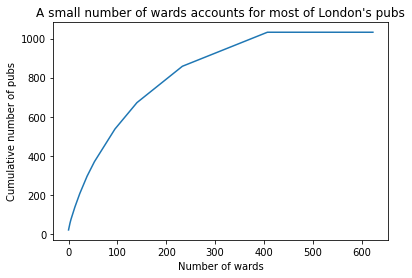

In [22]:
# Plot the cumulative number of pubs in top wards

feature_array = df_ward_pubs['Pub'].sort_values(ascending=False)
total_num_pubs = sum(feature_array)
running_total = 0
running_total_array = []

for value in feature_array:
    running_total += value #/ total_num_pubs
    running_total_array.append(running_total)

#plt.plot(np.linspace(0,1,len(feature_array)), running_total_array)
plt.plot(np.arange(0,len(feature_array), 1), running_total_array)
plt.title('A small number of wards accounts for most of London\'s pubs')
plt.xlabel('Number of wards')
plt.ylabel('Cumulative number of pubs')

print("Top 10 wards account for", running_total_array[9], "pubs")
print("Top 100 wards account for", running_total_array[99], "pubs")

In [23]:
# Plot a choropleth showing the geographic distribution of pubs

m = folium.Map(location=[51.515, -0.093], zoom_start=10)

folium.Choropleth(
    geo_data=ward_data,
    name='choropleth',
    data=df_ward_pubs,
    columns=['Code', 'Pub'],
    key_on='feature.properties.code',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = [0,1,3,10,25],
    legend_name='Number of pubs'
).add_to(m)

m

## Step 3 - Predictive analytics

In [24]:
regress_columns = df_wards.columns[3:]
df_wards = df_wards.merge(df_ward_pubs.drop(columns=['Ward']), how='right', on='Code')
df_wards.head()

Borough            Ward       Code  Population  \
0        City of London  City of London  E09000001        8100   
1  Barking and Dagenham           Abbey  E05000026       14750   
2  Barking and Dagenham          Alibon  E05000027       10600   
3  Barking and Dagenham       Becontree  E05000028       12700   
4  Barking and Dagenham  Chadwell Heath  E05000029       10400   

   Percentage under 15  Percentage 15-64   Mean age     Area  \
0             7.962057         76.886786  41.303887  3.15148   
1            25.958342         69.014180  29.500000  1.30000   
2            25.701332         64.276943  33.800000  1.40000   
3            25.370429         65.912673  33.000000  1.30000   
4            24.326923         61.500000  36.200000  3.40000   

   Population density  % BAME  ...  Deliberate fires rate  % area open space  \
0         2538.062371    21.4  ...               0.392259          18.629014   
1        10500.000000    71.9  ...               1.353078          21.908601   
2         7428.600000    29.9  ...               0.653778          20.621849   
3         9269.200000    41.2  ...               1.189626           1.885448   
4         2985.300000    37.9  ...               1.251444          55.974507   

   Cars per household  Public transport accessibility  % bicycle travel  \
0            0.385861                        7.862302          5.308616   
1            0.547682                        5.989365          0.801603   
2            0.815160                        3.145890          1.020408   
3            0.870236                        2.871766          1.647411   
4            0.918062                        2.260909          1.174668   

   Mayor election turnout  Any  Pub  Pub perc  Pub binary  
0               48.523652  167    3  0.017964           1  
1               25.688941   19    1  0.052632           1  
2               20.347925    5    1  0.200000           1  
3               22.538211    3    0  0.000000           0  
4               25.318814    6    0  0.000000           0  

[5 rows x 47 columns]

In [25]:
# Find which columns are most correlated with the number of pubs
df_wards.drop(columns=['Any', 'Pub binary', 'Pub perc']).corr()['Pub'].sort_values(ascending=False)[:5]

Pub                               1.000000
Public transport accessibility    0.419036
Percentage 15-64                  0.367445
% flats                           0.360025
% bicycle travel                  0.343985
Name: Pub, dtype: float64

In [26]:
df_wards.drop(columns=['Any', 'Pub binary', 'Pub perc']).corr()['Pub'].sort_values(ascending=True)[:5]

Percentage under 15         -0.395321
Fertility rate              -0.324243
% BAME                      -0.247717
Cars per household          -0.244353
Out-of-work benefits rate   -0.180345
Name: Pub, dtype: float64

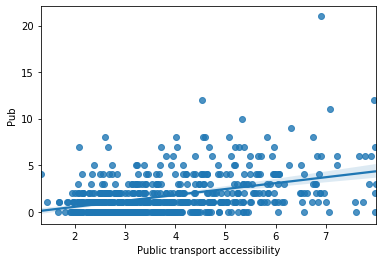

In [27]:
sns.regplot(data=df_wards, x='Public transport accessibility', y='Pub')

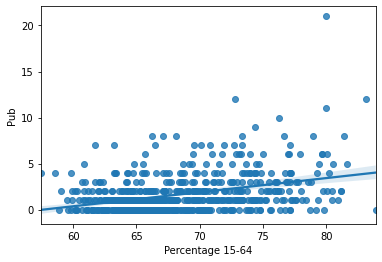

In [28]:
sns.regplot(data=df_wards, x='Percentage 15-64', y='Pub')

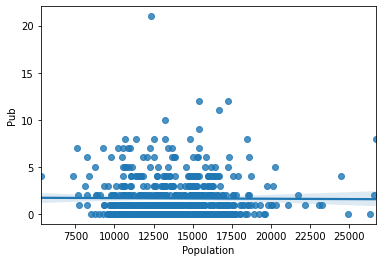

In [29]:
sns.regplot(data=df_wards, x='Population', y='Pub')

We can see that neighborhoods with high accessibility of public transport and a high share of working-age inhabitants tend to have more pubs on average. On the other hand, neighborhoods with more children under 15 and higher car ownership tend to have fewer pubs.

### 3B - Machine learning analyses

In [30]:
# Scale the data and split it into train and test sets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

X = df_wards[regress_columns]
X_scaled = scaler.fit_transform(X)

y = df_wards[['Pub', 'Pub binary', 'Any']]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("# train samples:", X_train.shape[0])
print("# test samples:", X_test.shape[0])

# train samples: 499
# test samples: 125


In [56]:
# Run a linear regression to predict number of pubs
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train['Pub'])

row_names = list(regress_columns)
row_names.insert(0, 'Intercept')
col_names = ['Coefficients']
coef = list(lr.coef_)
coef.insert(0, lr.intercept_)
coef_table = pd.DataFrame(coef, row_names, columns=col_names)
coef_table.sort_values(by='Coefficients', ascending=False).head(4)

Coefficients
Intercept                           1.634760
Public transport accessibility      1.126726
Cars per household                  1.050683
Median household income             0.412944

In [57]:
from sklearn.metrics import mean_squared_error

y_hat_test = lr.predict(X_test)

MSE = mean_squared_error(y_test['Pub'], y_hat_test)
RMSE = math.sqrt(MSE)

print('OOS RMSE:', RMSE)

OOS RMSE: 2.3080743752982213


In [34]:
# Run a LASSO regression with cross-validation

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso()
params = {'alpha': np.linspace(0.001, 0.5, 100)}

model_cv = GridSearchCV(estimator = lasso,
                param_grid = params,
                scoring  = 'neg_root_mean_squared_error',
                return_train_score=True,
                cv = 10)

model_cv.fit(X_train, y_train['Pub'])

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.001     , 0.0060404 , 0.01108081, 0.01612121, 0.02116162,
       0.02620202, 0.03124242, 0.0...
       0.3790303 , 0.38407071, 0.38911111, 0.39415152, 0.39919192,
       0.40423232, 0.40927273, 0.41431313, 0.41935354, 0.42439394,
       0.42943434, 0.43447475, 0.43951515, 0.44455556, 0.44959596,
       0.45463636, 0.45967677, 0.46471717, 0.46975758, 0.47479798,
       0.47983838, 0.48487879, 0.48991919, 0.4949596 , 0.5       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)

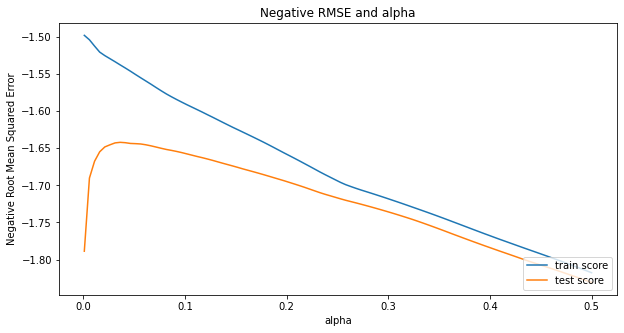

In [35]:
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(10,5))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Root Mean Squared Error')
plt.title("Negative RMSE and alpha")
plt.legend(['train score', 'test score'], loc='lower right')
plt.show()

In [36]:
print(model_cv.best_params_['alpha'])

0.036282828282828285


In [37]:
alpha_best = model_cv.best_params_['alpha']

lasso_best = Lasso(alpha=alpha_best)
lasso_best.fit(X_train, y_train['Pub'])

y_hat_test = lasso_best.predict(X_test)

MSE = mean_squared_error(y_test['Pub'], y_hat_test)
RMSE = math.sqrt(MSE)

print('OOS RMSE:', RMSE)

OOS RMSE: 2.282242110277597


In [40]:
# Run a polynomial LASSO regression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, interaction_only=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(X_train.shape)
print(X_train_poly.shape)

(499, 40)
(499, 861)


In [41]:
lasso_poly = Lasso(max_iter=10000, tol=0.001, random_state=42)
params = {'alpha': np.linspace(0.1, 0.2, 100)}

model_cv_poly = GridSearchCV(estimator = lasso_poly,
                param_grid = params,
                scoring  = 'neg_root_mean_squared_error',
                return_train_score=True,
                cv = 10)

model_cv_poly.fit(X_train_poly, y_train['Pub'])

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.1       , 0.1010101 , 0.1020202 , 0.1030303 , 0.1040404 ,
       0.10505051, 0.10606061, 0.10707071...
       0.17575758, 0.17676768, 0.17777778, 0.17878788, 0.17979798,
       0.18080808, 0.18181818, 0.18282828, 0.18383838, 0.18484848,
       0.18585859, 0.18686869, 0.18787879, 0.18888889, 0.18989899,
       0.19090909, 0.19191919, 0.19292929, 0.19393939, 0.19494949,
       0.1959596 , 0.1969697 , 0.1979798 , 0.1989899 , 0.2       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=0)

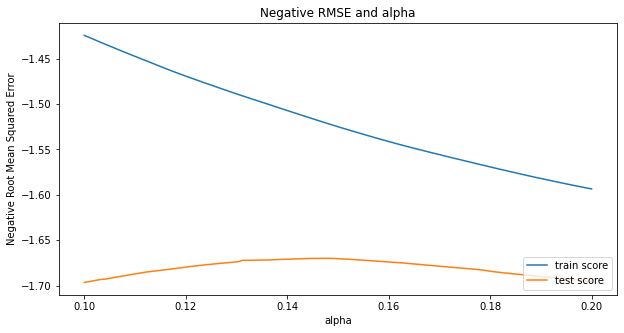

Best alpha: 0.14747474747474748


In [42]:
cv_results = pd.DataFrame(model_cv_poly.cv_results_)
plt.figure(figsize=(10,5))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Root Mean Squared Error')
plt.title("Negative RMSE and alpha")
plt.legend(['train score', 'test score'], loc='lower right')
plt.show()
print('Best alpha:', model_cv_poly.best_params_['alpha'])

In [43]:
alpha_best = model_cv_poly.best_params_['alpha']

lasso_best = Lasso(alpha=alpha_best)
lasso_best.fit(X_train_poly, y_train['Pub'])

y_hat_test = lasso_best.predict(X_test_poly)

MSE = mean_squared_error(y_test['Pub'], y_hat_test)
RMSE = math.sqrt(MSE)

print('OOS RMSE:', RMSE)

OOS RMSE: 2.2935440403567564


### 3C - Train the best model on full data and evaluate

Text(0, 0.5, 'Predicted number of Pubs')

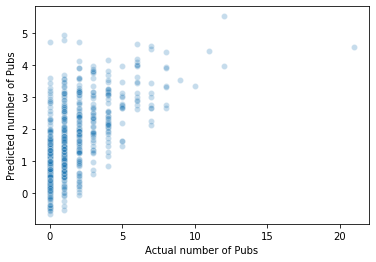

In [59]:
# Run a final LASSO regression using the full dataset

lasso_final = Lasso(alpha = 0.036282828282828285)

lasso_final.fit(X_scaled, y['Pub'])

y_hat = lasso_final.predict(X_scaled)

sns.scatterplot(y['Pub'], y_hat, alpha=0.25)
plt.xlabel('Actual number of Pubs')
plt.ylabel('Predicted number of Pubs')

In [49]:
y_hat_full = lr.predict(X_scaled)
residual = list(y_hat_full - y['Pub'])

df_result = pd.DataFrame({'Code':  df_wards['Code'], 'Residual': residual}, columns=['Code', 'Residual'])

# Choropleth of prediction vs reality
m = folium.Map(location=[51.515, -0.093], zoom_start=10)

folium.Choropleth(
    geo_data=ward_data,
    name='choropleth',
    data=df_result,
    columns=['Code', 'Residual'],
    key_on='feature.properties.code',
    tooltip='hey',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = [-20, -5, 0, 2, 5],
    legend_name="Residual (red = already have more pubs than expected)"
).add_to(m)

m

In [51]:
df_res_summary = df_wards[['Borough', 'Ward', 'Code']].copy()
df_res_summary['Actual number of Pubs'] = y['Pub']
df_res_summary['Predicted number of Pubs'] = y_hat_full
df_res_summary['Residual'] = y_hat_full - y['Pub']
df_res_summary.head()

Borough            Ward       Code  Actual number of Pubs  \
0        City of London  City of London  E09000001                      3   
1  Barking and Dagenham           Abbey  E05000026                      1   
2  Barking and Dagenham          Alibon  E05000027                      1   
3  Barking and Dagenham       Becontree  E05000028                      0   
4  Barking and Dagenham  Chadwell Heath  E05000029                      0   

   Predicted number of Pubs  Residual  
0                  2.458362 -0.541638  
1                  1.938019  0.938019  
2                  0.395724 -0.604276  
3                  0.324121  0.324121  
4                  0.078551  0.078551

In [52]:
# Most overserved wards
df_res_summary.sort_values(by='Residual', ascending=True).head(5)

Borough            Ward       Code  Actual number of Pubs  \
344   Islington     Clerkenwell  E05000370                     21   
599  Wandsworth     Thamesfield  E05000625                     12   
341   Islington         Bunhill  E05000367                     11   
354   Islington     St. Peter's  E05000380                     10   
110      Camden  Hampstead Town  E05000135                      8   

     Predicted number of Pubs   Residual  
344                  4.694256 -16.305744  
599                  4.594540  -7.405460  
341                  4.318428  -6.681572  
354                  3.466941  -6.533059  
110                  2.036385  -5.963615

In [53]:
# Most underserved wards
df_res_summary.sort_values(by='Residual', ascending=False).head(10)

Borough                         Ward       Code  \
390                 Lambeth                     Bishop's  E05000416   
118                  Camden  St. Pancras and Somers Town  E05000143   
587              Wandsworth                  East Putney  E05000613   
611             Westminster  Knightsbridge and Belgravia  E05000637   
104                  Camden                   Bloomsbury  E05000129   
404                 Lambeth               Streatham Hill  E05000430   
615             Westminster       Marylebone High Street  E05000641   
231  Hammersmith and Fulham                      Munster  E05000257   
585              Wandsworth                      Bedford  E05000611   
559           Tower Hamlets  St. Katherine's and Wapping  E05000585   

     Actual number of Pubs  Predicted number of Pubs  Residual  
390                      1                  5.257740  4.257740  
118                      0                  4.013692  4.013692  
587                      0                  4.008318  4.008318  
611                      2                  5.979743  3.979743  
104                      0                  3.948350  3.948350  
404                      0                  3.477101  3.477101  
615                      1                  4.408704  3.408704  
231                      0                  3.408122  3.408122  
585                      0                  3.151449  3.151449  
559                      0                  3.120407  3.120407

In [69]:
# Most underserved boroughs
df_res_summary.groupby('Borough').sum().sort_values(by='Residual', ascending=False).head(5)

Actual number of Pubs  Predicted number of Pubs   Residual
Borough                                                                  
Croydon                           15                 27.858362  12.858362
Lambeth                           48                 59.726802  11.726802
Tower Hamlets                     32                 41.964139   9.964139
Hackney                           34                 43.929577   9.929577
Havering                          20                 28.917847   8.917847

In [70]:
# Most overserved boroughs
df_res_summary.groupby('Borough').sum().sort_values(by='Residual', ascending=True).head(5)

Actual number of Pubs  Predicted number of Pubs  \
Borough                                                                   
Islington                                  79                 55.304999   
Richmond upon Thames                       60                 45.783482   
Hammersmith and Fulham                     49                 40.285286   
Waltham Forest                             29                 21.029980   
Enfield                                    20                 12.781831   

                         Residual  
Borough                            
Islington              -23.695001  
Richmond upon Thames   -14.216518  
Hammersmith and Fulham  -8.714714  
Waltham Forest          -7.970020  
Enfield                 -7.218169